This is the first in a series of posts on extracting word representations using statistical language modeling techniques. This first installment includes rudimentary corpus preprocessing, tokenization, vectorization, and inferences within the vector space model. The corpus is a public domain dataset of a million news headlines from the Australian Broadcasting Corporation between 2003 and 2021.

All code blocks for this part of the project are included in this document. The first block includes the imports used in this part of the project.

https://github.com/Using-Namespace-System/Syntagmatic-And-Paradigmatic-Word-Associations.git

The Whole series can be cloned from the link above into a dev container and the configs will include the necessary dependencies.

In [1]:
from itertools import zip_longest
from matplotlib.pyplot import figure
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from scipy.sparse import csr_array
from scipy.sparse import find
import pickle

df = pd.read_csv('../input/abcnews-date-text.csv')
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cuquantum/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preprocessing the corpus is simplified to filtering out short headlines, small words, and stop-words. Each action is completed in pandas, I believe this may improve readability. The documents are exploded into a single series representing the whole corpus. From here stop-words can be filtered out. No further sanitation is performed.  

In [2]:
#tokenize and sanitize

#tokenize documents into individual words
df['tokenized'] = df.headline_text.str.split(' ')

#remove short documents from corpus
df['length'] = df.tokenized.map(len)
df = df.loc[df.length > 1]

#use random subset of corpus
df=df.sample(frac=0.052).reset_index(drop=True)

#flatten all words into single series
ex = df.explode('tokenized')

#remove shorter words
ex = ex.loc[ex.tokenized.str.len() > 2]

#remove stop-words
ex = ex.loc[~ex.tokenized.isin(stopwords_set)]

Tokenization of the corpus is performed by creating forward and backwards lookup dictionaries. Each unique word is represented as a unique number. This is a very simple method of tokenization.

In [3]:
#create dictionary of words

#shuffle for sparse matrix visual
dictionary = ex.tokenized.drop_duplicates().sample(frac=1)

#dataframe with (index/code):word
dictionary = pd.Series(dictionary.tolist(), name='words').to_frame()

#store code:word dictionary for reverse encoding
dictionary_lookup = dictionary.to_dict()['words']

#offset index to prevent clash with zero fill
dictionary['encode'] = dictionary.index + 1

#store word:code dictionary for encoding
dictionary = dictionary.set_index('words').to_dict()['encode']

#use dictionary to encode each word to integer representation
encode = ex.tokenized.map(dictionary.get).to_frame()
encode.index.astype('int')
encode.tokenized.astype('int')
#un-flatten encoded words back into original documents
docs = encode.tokenized.groupby(level=0).agg(tuple)

#match up document indexes for reverse lookup
df = df.sort_index().iloc[docs.index].reset_index(drop=True)
docs = docs.reset_index()['tokenized']



In its simplest form the word vector for each term would be the one-hot(binary) encoding of the documents they are (1) and are not (0) present in. Likewise, the transform is comprised of document-word vectors where each is a one-hot encoding of the terms in the corpus that are and are not present in a document.

In this instance the word vector is a count vector. This is similar to one-hot but is able to convey how many times the term occurred in the document.

For the news headline dataset, document-wise term repetition is minimal and the statistical weight it provides is negligible.

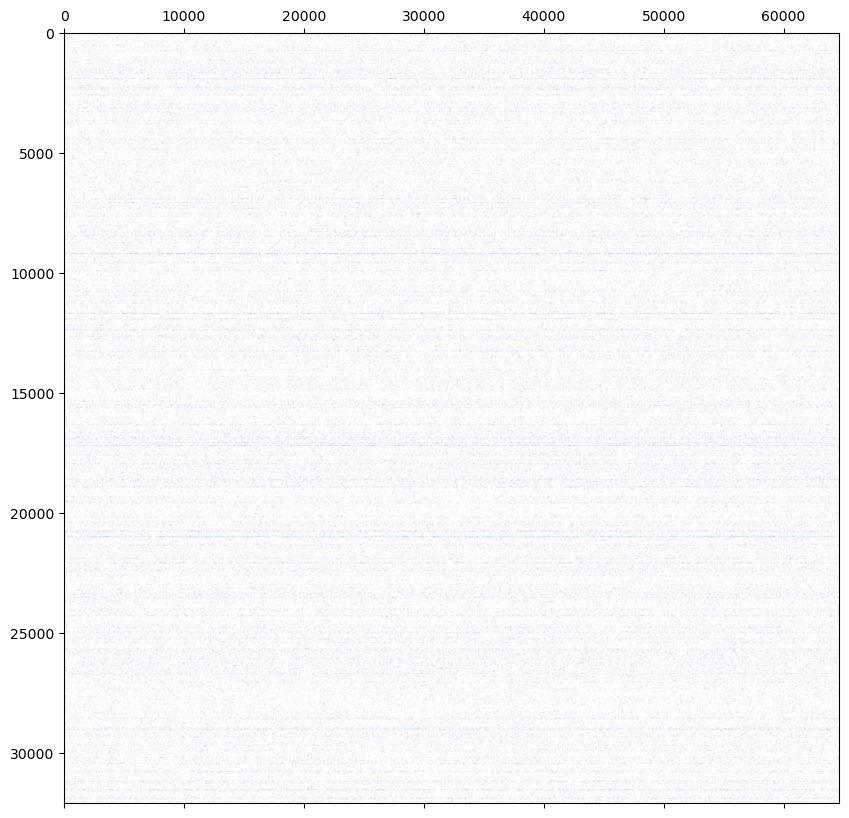

In [4]:

#zero pad x dimension by longest sentence
encoded_docs = list(zip(*zip_longest(*docs.to_list(), fillvalue=0)))

#convert to sparse matrix
encoded_docs = csr_array(encoded_docs, dtype=int)

#convert to index for each word
row_column_code = find(encoded_docs)

#presort by words
word_sorted_index = row_column_code[2].argsort()
doc_word = np.array([row_column_code[0][word_sorted_index], row_column_code[2][word_sorted_index]])

#presort by docs and words
doc_word_sorted_index = doc_word[0].argsort()
doc_word = pd.DataFrame(np.array([doc_word[0][doc_word_sorted_index], doc_word[1][doc_word_sorted_index]]).T, columns=['doc','word'])

#offset code no longer needed after zero-fill
doc_word.word = doc_word.word - 1

#convert to index of word counts per document
doc_word_count  = doc_word.groupby(['doc','word']).size().to_frame('count').reset_index().to_numpy().T

#convert to sparse matrix
sparse_word_doc_matrix = csr_array((doc_word_count[2],(doc_word_count[0],doc_word_count[1])), shape=(np.size(encoded_docs, 0),len(dictionary)), dtype=float).T

#visualize sparse matrix
fig = figure(figsize=(10,10))
sparse_word_doc_matrix_visualization = fig.add_subplot(1,1,1)
display(sparse_word_doc_matrix_visualization.spy(sparse_word_doc_matrix, markersize=0.007, aspect = 'auto'))

The visualization below shows the words (y-axis) and the documents (x-axis) they are in. Across 600000 documents the terms in the corpus that re-occur more regularly form an interesting pattern of lines.

The words that occur together often in the corpus also, as word vectors, are closer together in this 600000 dimensional vector space. This is demonstrated in the table below.

In [5]:
#approximating cosine similarity with dot product of the term document matrix and its transform

similarity_matrix  = sparse_word_doc_matrix @ sparse_word_doc_matrix.T

#displaying slice of matrix with highest similarity scores

similarity_matrix_compressed = similarity_matrix[(-similarity_matrix.sum(axis = 1)).argsort()[:6]].toarray()

similar_words = pd.DataFrame((-similarity_matrix_compressed).argsort(axis = 1)[:6,:6].T)

display(similar_words)

similar_words.applymap(dictionary_lookup.get)

,0,1,2,3,4,5
0,9152,11673,20986,1881,692,12328
1,20986,1898,22396,22058,20986,9152
2,12381,10596,9152,24757,17097,2547
3,22569,8275,692,4563,15512,24757
4,12153,9152,4428,11673,16229,10316
5,17193,31170,21313,3103,4428,1488


/tmp/ipykernel_106712/2616535572.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  similar_words.applymap(dictionary_lookup.get)


,0,1,2,3,4,5
0,police,new,man,says,court,nsw
1,man,zealand,charged,government,man,police
2,probe,york,police,govt,accused,rural
3,investigate,laws,court,labor,face,govt
4,missing,police,murder,new,told,hour
5,search,australia,jailed,minister,murder,country


The documents with the most similarities are closer together in the vector space.

In [6]:
#previewing document similarity

doc_similarity_matrix  = sparse_word_doc_matrix.T @ sparse_word_doc_matrix

#displaying slice of matrix with highest similarity scores

doc_similarity_matrix_compressed = doc_similarity_matrix[(-doc_similarity_matrix.sum(axis = 1)).argsort()[:6]].toarray()

pd.DataFrame((-doc_similarity_matrix_compressed).argsort(axis = 1)[:6,:6].T).applymap(df.headline_text.to_dict().get)

/tmp/ipykernel_106712/1211479390.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.DataFrame((-doc_similarity_matrix_compressed).argsort(axis = 1)[:6,:6].T).applymap(df.headline_text.to_dict().get)


,0,1,2,3,4,5
0,woman set on fire by man in medina home in per...,police search lake after man evades police,new york police release video of man stealing ...,nsw police charge man road rage brawl in weste...,buffalo new york police man push ground united...,nsw police charge man over sydney couples murder
1,police say elderly woman was strangled in own ...,police trackers remembered for nt police force...,buffalo new york police man push ground united...,nsw police charge three over alleged western s...,new york police release video of man stealing ...,nsw police charge man road rage brawl in weste...
2,police say man in strangers home died of drug,police search williamtown for missing man,new york police officers shot dead in brooklyn,nsw police charge man over sydney couples murder,new york police officers shot dead in brooklyn,police charge eden hills man with attempted mu...
3,man and woman charged over violent tenambit ho...,police search for missing man in south mackay,man jailed for stealing card from a dying man ...,police charge man over sydney stabbing,andrew cuomo new york buffalo officers protests,nsw police charge three over alleged western s...
4,fatal house fire not suspicious say police,police call for inquest into police witness mu...,police investigating assaults release image of...,police say road rage may have played part in c...,donald trump chokeholds police protests united...,police charge man over sydney stabbing
5,man shot in leg in perth home invasion,police search for man who bashed woman fled wi...,thief steals pot of gold off armoured truck in...,police charge man over sword attack,teenage gunman shot dead new york police,vic police charge man over murder


In [7]:
with open('./sparse_word_doc_matrix.obj', 'wb') as file:
    pickle.dump(sparse_word_doc_matrix,file)